In [93]:
import imageio
import glob
import re
from random import sample, seed
import os
import matplotlib.pyplot as plt
import numpy as np
from math import *

In [17]:
seed(20)
if os.name == 'nt': # Windows
    system_win = 1
else:
    system_win = 0

In [187]:
# This function will read a series of PNG file and convert its content to a 3d  array containing the volume, 
# Param: filePath: the file path of the PNG files. Each file should be named as 1.png, 2.png, 3.png ... etc. All the png file should 
#                  be ordered by the their topological order from their original dicom file
#        padding: If set to an interger x, then each png image will be copied x times and these slices will all be added
#               to the volume. This is used to pad between the slices.
# Return: a 3d numpy array representing the volume containing the stack of the png images and their copies.

def ReadPointFromPNG(filepath, padding:int):
    print("---------------")
    print("Begin reading points data from PNG files")
    path_list = [im_path for im_path in glob.glob(filepath)]
    
    if system_win:
        path_list_parsed = [re.split('\\\\|\.', path) for path in path_list]
    else:
        path_list_parsed = [re.split('/|\.', path) for path in path_list]
    path_list_parsed_valid = [x for x in path_list_parsed if x[-1] == 'png']
    path_list_parsed_valid = sorted(path_list_parsed_valid, key=lambda x:int(x[-2]))
    
    print("There are", len(path_list_parsed_valid),"PNG files, now concatinate them into a single 3D array")
    imageData = []
    
    for path in path_list_parsed_valid:
        s = ""
        if system_win:
            s = "\\"
        else:
            s = "/"
        s = s.join(path)
        s = s[:-4] + '.png'
        image = imageio.imread(s)
        
        for i in range(padding):
            imageData.append(image)
            
    imageData = np.asarray(imageData)
    imageData = np.rot90(imageData, 1, (0, 2))
    imageData = np.rot90(imageData, 1, (1, 0))
    print("Done!")
    return imageData

In [216]:
# Given a 3d volume, a plane's parameter (a,b,c,d as in ax + by + cz + d = 0) and the center point coordinate (must be on
# the plane specified), return the image correspond to the plane, centered at the certer point's location
# Param: data_volume: a 3d numpy array containing the volume data
#        planeParam: parameters of a plane (a,b,c,d as in ax + by + cz + d = 0)
#        centerPoint: the 3d coordinate of a point. The point has to be on the plane. The result image will be centered
#                     by this point. 
#        range: how large the result image will be. The larger the image, the slower the computation

def getTangentPlane (data_volume, planeParam, centerPoint, resultRange: int = 100):
    
    a, b, c, d = planeParam
    
    if(a * centerPoint[0] + b * centerPoint[1] + c * centerPoint[2] + d != 0):
        print("error: center point is not on the plane!")
        return
    
    data_volume = np.asarray(data_volume)
    bounds = data_volume.shape

    if( a == 0 and b !=0 and c != 0):
        u = np.array([0, 0, -d/c]) - np.array([0, -d/b , 0])
        u = u / np.linalg.norm(u)
    elif( b == 0 and a !=0 and c != 0):
        u = np.array([0, 0, -d/c]) - np.array([-d/a, 0, 0])
        u = u / np.linalg.norm(u)
    elif( c == 0 and a !=0 and b != 0):
        u = np.array([0, -d/b, 0]) - np.array([-d/a, 0, 0])
        u = u / np.linalg.norm(u)
    elif(a == 0 and b == 0):
        u = np.array([1, 0, 0])
    elif(a == 0 and c == 0):
        u = np.array([0, 0, 1])
    elif(b == 0 and c == 0):
        u = np.array([0, 0, 1])
    elif(a == 0 or b == 0 or c == 0):
        print("plane parameter error! a =", a, "b =", b, "c =", c, "d =", d)
    else:
        u = np.array([0, 0, -d/c]) - np.array([1, 1, (-d - a - b)/c])
         
    normal = np.array([a, b, c])
    normal = normal / np.linalg.norm(normal)
    v = np.cross(u, normal)
    v = v / np.linalg.norm(v)
    
    halfDiagnalLength = resultRange
    planeImg = np.zeros((halfDiagnalLength*2, halfDiagnalLength*2))
    
    # filling the 2d Image, this part can be further optimized by using matrix
    for x in range(-halfDiagnalLength, halfDiagnalLength):
        for y in range(-halfDiagnalLength, halfDiagnalLength):
            vectorElem1 = x*u
            vectorElem2 = y*v
            volumeCor = vectorElem1 + vectorElem2 + centerPoint
            #Check boundary
            if(volumeCor[0] > 0 and volumeCor[0] < bounds[0] and volumeCor[1] > 0 and volumeCor[1] < bounds[1] and\
              volumeCor[2] > 0 and volumeCor[2] < bounds[2]):
                volxelVal = data_volume[floor(volumeCor[0])][floor(volumeCor[1])][floor(volumeCor[2])]
                planeImg[x + halfDiagnalLength][y + halfDiagnalLength] = volxelVal
        
    return planeImg

In [188]:
filePath = 'mri_image_2016/*.png'
data = ReadPointFromPNG(filePath, 2)

---------------
Begin reading points data from PNG files
There are 144 PNG files, now concatinate them into a single 3D array
Done!


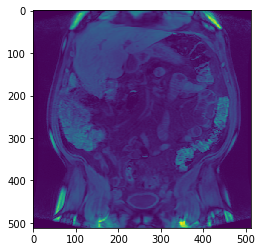

In [205]:
plt.imshow(data[:, :, 100])

In [212]:
plane = 0.05, -0.05, 1, -100
center = np.array([250, 250, 100])

In [213]:
result = getTangentPlane (data, plane, center)

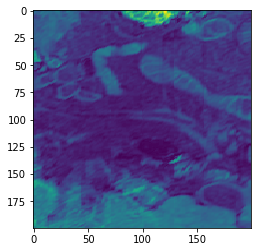

In [214]:
plt.imshow(result)